# Binäre Klassifikation - Bewertung

<TODO: hier beschreiben, was in diesem JN behandelt wird>

In [12]:
# --- imports
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd

from sklearn import metrics 

from scipy import stats

## Daten für habitable Planeten

Nachdem für eine kleine Menge von Exoplanten die Untersuchung auf habitable Planten durchgeführt wurde,
wird nun die komplette Menge der derzeit verfügbaren Daten herangezogen. Auf der Webseite https://phl.upr.edu/hwc
des Planet Habitability Laboratory, gemanaged von der University of Puerto Rico in Arecibo, 
sind Daten der aktuellen entdeckten Exoplaneten. Die Daten wurden am 22.08.2024 exportiert.

In der Tabelle sind viele Daten über die Exoplantene hinterlegt. 
Es werden nur die Spalten 
- `S_MASS` (Masse des Sterns in Sonnenmassen), 
- `P_PERIOD` (Umlaufzeit des Planeten in Tagen),
- `P_DISTANCE` (Entfernung des Planeten zum Stern in Astronomischen Einheiten (AU)) und
- `P_HABITABLE` (Kennzeichen, ob habitable (1 optimistische Einschätzung, 2 konservative Einschätzung))

selektiert.

Nach der Auswahl der für die Untersuchung benötigten Spalten werden diejenigen Zeilen gelöscht, in denen Daten fehlen.
Es werden also diejenigen Zeilen gelöscht, in denen in den vier wichtigen Spalten Daten fehlen, 
also ein `NaN`(not a number) eingetragen ist. 

Es gibt auch andere Möglichkeiten mit fehlenden Daten umzugehen.
Beispielsweise können fehlende Daten ergänzt werden, etwa durch den Mittelwert der anderen Daten. 
Dieses Verfahren wird *imputing* genannt.
Die Aufbereitung von Daten kann eine schwierige Aufgabe sein. Dies soll hier nicht weiter betrachtet werden.
Da ist es dann notwendig, tiefer in die Möglichkeiten von `pandas` einzutauchen, was hier nicht gemacht wird.

Da für die Kennzeichenung von habitablen Exoplaneten insgesamt drei Kennzeichen verwendet werden
- 0 für nicht habitabel
- 1 für habitabel nach einer optimistischen Einschätzung und
- 2 für habitabel nach einer konservativen Einschätzung

wird in der Spalte `P_HABITABLE`jede 2 durch eine 1 ersetzt. Dies bedeutet dan möglicherweise habitabel.
Damit ergibt sich ein binäres Klassifikationsproblem.

In [2]:
# --- read the data - complete
filename = 'hwc.csv'
df_hwc = pd.read_csv (filename, sep=',')

# --- select the columns for the analysis
df_selected_columns = df_hwc [['S_MASS', 'P_PERIOD', 'P_DISTANCE', 'P_HABITABLE']]
print (f"number of exoplanets in the raw list : {df_selected_columns.shape [0]}  (still with NaN-values)")

# --- remove the rows with NaN-values
df_removed_rows = df_selected_columns.dropna (axis = 0)
print (f"number of exoplanets in the     list : {df_removed_rows.shape [0]}  (without any NaN-values)")
print ()
print (df_removed_rows.groupby ('P_HABITABLE').count())

# --- replace value 2 to 1 in column P_HABITABLE
df_removed_rows.loc [df_removed_rows.P_HABITABLE == 2, "P_HABITABLE"] = 1
print ()
print (df_removed_rows.groupby ('P_HABITABLE').count())

number of exoplanets in the raw list : 5599  (still with NaN-values)
number of exoplanets in the     list : 5350  (without any NaN-values)

             S_MASS  P_PERIOD  P_DISTANCE
P_HABITABLE                              
0              5280      5280        5280
1                29        29          29
2                41        41          41

             S_MASS  P_PERIOD  P_DISTANCE
P_HABITABLE                              
0              5280      5280        5280
1                70        70          70


Nun werden die Daten in Input-Daten (*feature data*) und Output-Daten (*target data*) aufgeteilt.

In [3]:
# --- split into features and targets
features = df_removed_rows [['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
targets = df_removed_rows [['P_HABITABLE']]

# --- overview of important statistical key figures
print (features.describe ())

print (features.head ())
print (targets.head ())

            S_MASS      P_PERIOD   P_DISTANCE
count  5350.000000  5.350000e+03  5350.000000
mean      0.967725  7.994082e+04     2.298436
std       0.394993  5.498596e+06   103.218178
min       0.010000  9.070629e-02     0.004408
25%       0.810000  4.465382e+00     0.051900
50%       0.950000  1.156951e+01     0.096550
75%       1.100000  4.150555e+01     0.232000
max      10.940000  4.020000e+08  7506.000000
   S_MASS   P_PERIOD  P_DISTANCE
1    1.10  31.884000      0.1994
2    0.98   6.883376      0.0678
3    0.89   1.921036      0.0291
4    0.87  11.119907      0.0911
5    0.68   7.493134      0.0657
   P_HABITABLE
1            0
2            0
3            0
4            0
5            0


Die statistischen Kennzahlen zeigen, dass es Ausreißer in den Daten gibt.
Es gibt extreme Werte (`max`), die weit vom Mittelwert (`mean`) oder dem Median (`50%`) entfernt sind.
Extreme Ausreißer werden eliminiert.
Dazu wird hier definiert, dass ein Wert ein extremer Ausreißer ist, wenn er größer als Mittelwert plus das 
fünffache der Standardabweichung (`std`) ist. Extreme in negativer Richtung treten nicht auf!

Dass es Ausreißer gibt kann auch dadurch bemerkt werden, dass ein Histogramm geplottett wird.

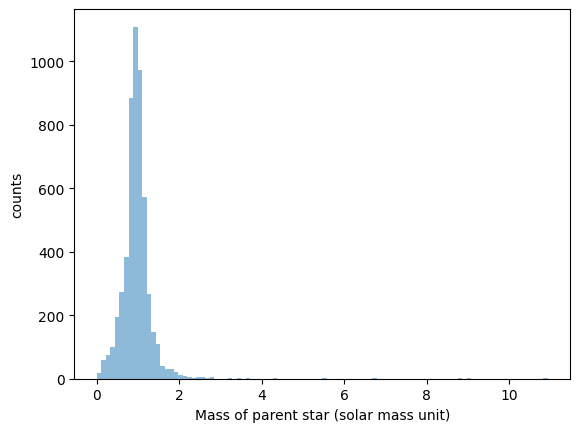

In [4]:
plt.hist(features.iloc[:,0], bins = 100, alpha = 0.5)
plt.xlabel ("Mass of parent star (solar mass unit)")
plt.ylabel ("counts")
plt.show ()

In [5]:
print (features.size)
features_new = features [(np.abs (stats.zscore (features)) < 5).all (axis=1)] 
print (features_new.size)
print (features_new.index.size)
print (targets.size)

16050
16017
5339
5350


In [6]:
print (type (features_new))
print (features_new.columns)
print (type (targets))
print (targets.columns)
targets_new = targets ['P_HABITABLE'] [features_new.index]
print (targets)

<class 'pandas.core.frame.DataFrame'>
Index(['S_MASS', 'P_PERIOD', 'P_DISTANCE'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['P_HABITABLE'], dtype='object')
      P_HABITABLE
1               0
2               0
3               0
4               0
5               0
...           ...
5592            0
5594            0
5595            0
5596            0
5597            0

[5350 rows x 1 columns]


In [7]:
features_new = features_new.reset_index (drop=True)
targets_new = targets_new.reset_index (drop=True)

print (features_new)
print (targets_new)

      S_MASS     P_PERIOD  P_DISTANCE
0       1.10    31.884000    0.199400
1       0.98     6.883376    0.067800
2       0.89     1.921036    0.029100
3       0.87    11.119907    0.091100
4       0.68     7.493134    0.065700
...      ...          ...         ...
5334    0.84     3.770150    0.044721
5335    1.21  3999.000000    5.205792
5336    1.25   146.050000    0.596704
5337    0.99    29.334340    0.180159
5338    0.84     8.411200    0.076849

[5339 rows x 3 columns]
0       0
1       0
2       0
3       0
4       0
       ..
5334    0
5335    0
5336    0
5337    0
5338    0
Name: P_HABITABLE, Length: 5339, dtype: int64


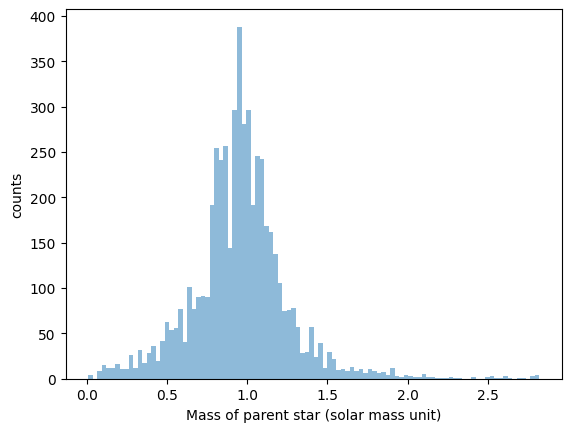

In [8]:
plt.hist(features_new.iloc[:,0], bins = 100, alpha = 0.5)
plt.xlabel ("Mass of parent star (solar mass unit)")
plt.ylabel ("counts")
plt.show ()

Für die beiden anderen Input-Daten sieht die Verbesserung des Histogramms leider nicht so gut aus. 
Da sind die Stndardabweichungen durch extreme Ausreißer sehr hoch!

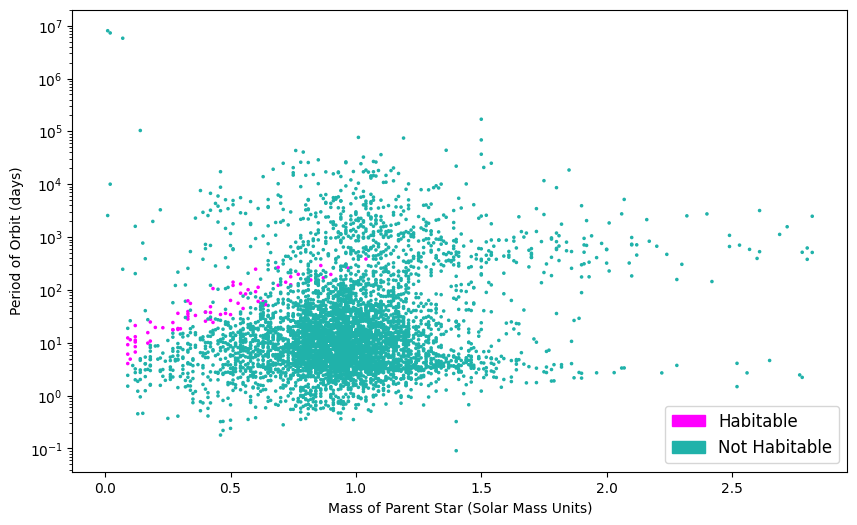

In [9]:
plt.figure(figsize=(10,6))

COL_NOT_HABITABLE = '#20B2AA'
COL_HABITABLE = '#FF00FF'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list ("cmap", [COL_NOT_HABITABLE, COL_HABITABLE])

#a = plt.scatter(final_features['S_MASS'], final_features['P_PERIOD'], marker = '.',\
#            c = targets, s = 100, cmap=cmap, label = 'Test')
a = plt.scatter(features_new ['S_MASS'], features_new ['P_PERIOD'], marker = '.',\
            c = targets_new, s = 10, cmap=cmap, label = 'Test')
plt.legend()

plt.yscale('log')
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

bluepatch = mpatches.Patch (color=COL_NOT_HABITABLE, label='Not Habitable')
magentapatch = mpatches.Patch (color=COL_HABITABLE, label='Habitable')

ax = plt.gca()
leg = ax.get_legend()

plt.legend(handles=[magentapatch, bluepatch],\
           loc = 'lower right', fontsize = 12)
plt.show ()

Aufgabe:
- Anwendung der Modell DT (1. und 2. Modell) und kNN auf diese größeren Datenmengen
- Betrachtung der Güte
- Betrachtung der Rechenzeit


## Bewertungen
Die **Geanuigkeit** (*accuracy*) wurde bereits in vorherigen Untersuchungen berechnet.
Es ist der Quotient zwischen korrekten Vorhersagen und allen Elementen.
Beim Beispiel der habitablen Exoplaneten gibt es 70 habitable Exoplaneten von insgesmat 5350 untersuchten Exoplanten.
Wenn automatisch jeder Exoplanet als nicht habitable vorhergesagt wird (*faule Zuordnung*), 
dann ist die Genauigkeit bei $(5350 - 70) / 5350 = 0.987$, also bei $98.7 \%$.
Ein scheinbar hervorragender Wert. Dieser Wert ergibt sich jedoch, da es fast 
keine habitablen Exoplaneten gibt. Daher ist bei dieser extrem unausgeglichenen Menge 
die Aussagekraft des Modells sehr gering.

### Genauigkeit, Präzision und Trefferquote
Bei einer binären Klassifikation gibt es für jedes Elemente zwei mögliche Klassen
und zwei mögliche Vorhersagen.
Die beiden Klassen werden mit positiv (**P**) und negativ (**N**) bezeichnet.
Die positive Klasse ist die Basis- oder Grundklasse (*ground truth*).
Im Beispiel der habitablen Exoplaneten stehe **P** für habitable und **N** für nicht habitabel.
Die Vorhersage für die Elemente können wahr (True, **T**) sein, die Klasse wurde richtig vorhergesagt, 
oder falsch (False, **F**)  sein, die Klasse wurde nicht richtig vorhergesagt. 
Daher gibt es vier Kennzahlen:
- TP (true positives): die Anzahl der Elemente, bei denen das positive Merkmal korrekt vorhergesagt wurde
  (korrekt klassifiziert als positiv),
- TN (true negatives): die Anzahl der Elemente, bei denen das negative Merkmal korrekt vorhergesagt wurde
  (korrekt klassifiziert als negativ),
- FP (false positives): die Anzahl der Elemente, bei denen das positive Merkmal nicht korrekt vorhergesagt wurde
  (nicht korrekt klassifiziert als positiv) und
- FN (false negatives): die Anzahl der Elemente, bei denen das negative Merkmal nicht korrekt vorhergesagt wurde
  (nicht korrekt klassifiziert als negativ).

Somit betrachtet der zweite Buchstabe (P / N) die Klassifikation durch das Modell. 
Der erste Buchstabe (T / F) besagt, ob die getroffene Klassifizierung korrekt (T) oder icht korrekt (F) ist.

Die **Genauigkeit** (*accuracy*) ist damit definiert durch
$$ accuracy = \frac{TN + TP}{TP + TN + FP + FN} .$$
Es können damit zwei weitere wichtige Kennzahlen definiert werden.

Die **Präzision** (*precision*) 
$$ precision = \frac{TP}{TP + FP} $$
ist der Anteil der Elemente in der positiven Klasse, die korrekt vorhergesagt wurden.
Die **Trefferquote** (*recall*) 
$$ recall = \frac{TP}{TP + FN} $$
ist der Anteil der korrekt vorhergesagten Elemente in der Menge, die als positiv vorhergesagt wurden.

Bei dem obigen Beispiel der habitablen Exoplanten mit der *faulen Zuordnung* ist 
die Präzision undefiniert, das $TP + FP = 0$, die Trefferquoto ist $0 = 0 / (0 + 70)$.
Das zeigt, dass die *faule Zuordnung* zwar einehohe Genauigkeit hat, aber nicht brauchbar ist.

**Hinweis**: Präzision und Trefferquote sind nicht symmetrisch. 
Werden die positive und negative Klasse getauscht, 
dann ergeben sich (mit den bisherigen Bezeichnungen) 
$precision = TN / (TN + FN) = 1$ und $recall = TN / (TN + FP) = 0.987$.
Dies sind komplett andere Werte. 
Daher ist es wichtig darauf zu achten, welches die positive Klasse ist!


0.8
[[8 0]
 [2 0]]


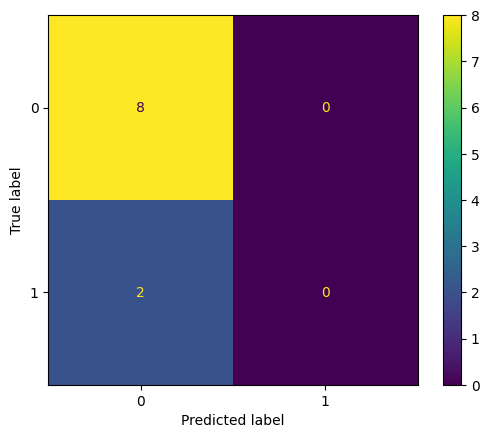

In [22]:

y_true = np.asarray ([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])
y_test = np.asarray ([0, 0, 0, 0 ,0 ,0, 0 ,0, 0, 0])

print(metrics.accuracy_score(y_true, np.zeros(len(y_test)))) #performance of a dummy classifier

cm = metrics.confusion_matrix(y_true, y_test)
print (cm)
labels = ['not hab', 'hab']
#metrics.confusion_matrix (y_true, y_test, labels = labels)

metrics.ConfusionMatrixDisplay.from_predictions (y_true, y_test)
